# Library Imports

In [1]:
import ezdxf
import matplotlib.pyplot as plt
from ezdxf.addons.drawing.matplotlib_backend import MatplotlibBackend
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.groupby import groupby
from pygcode import *

# Import DXF File and Create Image

In [2]:
def get_dxf(file_loc):
    doc = ezdxf.readfile(file_loc)
    msp = doc.modelspace()
    group = groupby(entities=msp, dxfattrib='layer')
    
    layout = doc.layouts.get('Model')
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(layout, finalize=True)
    plt.show()
    out.finalize()
    fig.savefig('Images/Outputs/dxf_output.png', dpi=600)
    
    return doc, msp, group

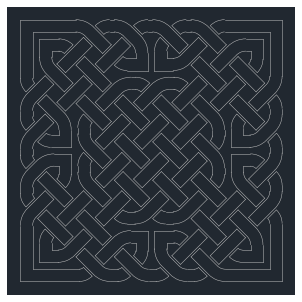

In [3]:
doc, msp, group = get_dxf("DXF/knot_005.dxf")

# Print DXF Entities

In [4]:
def print_line(e):
    print("LINE:")
    print("start point: %s" % e.dxf.start)
    print("end point: %s\n" % e.dxf.end)

In [5]:
def print_arc(e):
    print("ARC:")
    print("start point: %s" % e.start_point)
    print("end point: %s" % e.end_point)
    print("start angle: %s" % e.dxf.start_angle)
    print("end angle: %s" % e.dxf.end_angle)
    print("radius: %s\n" % e.dxf.radius)

In [6]:
def print_circle(e):
    print("Circle:")
    print("centre point: %s" % e.dxf.center)
    print("radius: %s\n" % e.dxf.radius)

In [7]:
def print_poly(e):
    print("POLYLINE:")
    print("THIS POLYLINE CONTAINS:\n")
    for entity in e.virtual_entities():
        if entity.dxftype() == 'LINE':
            print_line(entity)
        elif entity.dxftype() == 'ARC':
            print_arc(entity)
    print('-'*40)

In [8]:
def list_entities(group):
    for layer, entities in group.items():
        print(f'Layer "{layer}" contains following entities:')
        for entity in entities:
            print('    {}'.format(str(entity)))
        print('-'*40)

In [9]:
#list_entities(group)

In [10]:
def print_all_info(msp):
    for e in msp:
        if e.dxftype() == 'LINE':
            print_line(e)
        elif e.dxftype() == 'ARC':
            print_arc(e)
        elif e.dxftype() == 'CIRCLE':
            print_circle(e)
        elif e.dxftype() == 'POLYLINE':
            print_poly(e)

In [11]:
print_all_info(msp)

LINE:
start point: (2.984569, 5.501396, 0.0)
end point: (3.129569, 5.646396, 0.0)

LINE:
start point: (2.889569, 6.706396, 0.0)
end point: (2.889569, 5.730746, 0.0)

LINE:
start point: (3.094669, 6.501296, 0.0)
end point: (3.094669, 5.730652, 0.0)

LINE:
start point: (2.889569, 6.706396, 0.0)
end point: (3.812792, 6.706396, 0.0)

LINE:
start point: (3.094669, 6.501296, 0.0)
end point: (3.812886, 6.501296, 0.0)

LINE:
start point: (3.209569, 6.386396, 0.0)
end point: (3.528147, 6.386396, 0.0)

LINE:
start point: (3.414669, 6.181296, 0.0)
end point: (3.528241, 6.181296, 0.0)

LINE:
start point: (3.209569, 6.386396, 0.0)
end point: (3.209569, 6.086102, 0.0)

LINE:
start point: (3.414669, 6.181296, 0.0)
end point: (3.414669, 6.086007, 0.0)

LINE:
start point: (4.38099, 6.706396, 0.0)
end point: (4.452792, 6.706396, 0.0)

LINE:
start point: (4.380896, 6.501296, 0.0)
end point: (4.452886, 6.501296, 0.0)

LINE:
start point: (4.814469, 6.146785, 0.0)
end point: (4.814469, 6.061496, 0.0)

LINE:

# Convert Entities to GCODE

In [12]:
def line_to_gcode(e):
    x_start = e.dxf.start[0]
    y_start = e.dxf.start[1]
    x_end = e.dxf.end[0]
    y_end = e.dxf.end[1]
    gcode = [
        GCodeRapidMove(X=x_start,Y=y_start),
        GCodeLinearMove(X=x_end,Y=y_end),
    ]
    return gcode

In [13]:
def arc_to_gcode(e):
    x_start = str(round(e.start_point[0], 3))
    y_start = str(round(e.start_point[1], 3))
    a_start = str(round(e.dxf.start_angle, 3))
    a_end = str(round(e.dxf.end_angle, 3))
    radius = str(round(e.dxf.radius, 3))
    gcode = [
        "G03 R " + radius + " X" + x_start + " Y" + y_start + " S" + a_start + " E" + a_end,
    ]
    return gcode

In [14]:
def circle_to_gcode(e):
    x_center = e.dxf.center[0]
    y_center = e.dxf.center[1]
    radius = e.dxf.radius
    
    x_start = x_center
    y1_start = x_center + radius
    
    x1_end = x_center
    y1_end = x_center - radius
    
    x2_end = x_center
    y2_end = y1_start
    
    gcode = [
        GCodeRapidMove(X=x_start,Y=y1_start),
        GCodeArcMoveCCW(X=x1_end,Y=y1_end, R=radius),
        GCodeArcMoveCCW(X=x2_end,Y=y2_end, R=radius),
    ]
    return gcode

In [15]:
def poly_to_gcode(e):
    gcodes =[]
    for entity in e.virtual_entities():
        if entity.dxftype() == 'LINE':
            gcode = line_to_gcode(entity)
            for g in gcode:
                gcodes.append(str(g))
        if entity.dxftype() == 'ARC':
            gcode = arc_to_gcode(entity)
            for g in gcode:
                gcodes.append(str(g))
    return gcodes

# Ouput all GCODE to file

In [16]:
def output_all_info(msp, filename):
    all_instructions = []
    gcodes = []
    for e in msp:
        if e.dxftype() == 'LINE':
            gcode = line_to_gcode(e)
            for g in gcode:
                all_instructions.append(str(g))
        if e.dxftype() == 'ARC':
            gcode = arc_to_gcode(e)
            for g in gcode:
                all_instructions.append(str(g))
        if e.dxftype() == 'CIRCLE':
            gcode = circle_to_gcode(e)
            for g in gcode:
                all_instructions.append(str(g))
        if e.dxftype() == 'POLYLINE':
            gcodes = poly_to_gcode(e)
            all_instructions.extend(gcodes)
    
    File_object = open(filename,"w")
    for gcode in all_instructions:
        print(gcode)
        File_object.write(gcode + ";\n")
    File_object.close()

In [17]:
output_all_info(msp, "output3.gcode")

G00 X2.985 Y5.501
G01 X3.13 Y5.646
G00 X2.89 Y6.706
G01 X2.89 Y5.731
G00 X3.095 Y6.501
G01 X3.095 Y5.731
G00 X2.89 Y6.706
G01 X3.813 Y6.706
G00 X3.095 Y6.501
G01 X3.813 Y6.501
G00 X3.21 Y6.386
G01 X3.528 Y6.386
G00 X3.415 Y6.181
G01 X3.528 Y6.181
G00 X3.21 Y6.386
G01 X3.21 Y6.086
G00 X3.415 Y6.181
G01 X3.415 Y6.086
G00 X4.381 Y6.706
G01 X4.453 Y6.706
G00 X4.381 Y6.501
G01 X4.453 Y6.501
G00 X4.814 Y6.147
G01 X4.814 Y6.061
G00 X5.02 Y6.147
G01 X5.02 Y5.856
G00 X4.677 Y6.061
G01 X4.814 Y6.061
G00 X4.677 Y5.856
G01 X5.02 Y5.856
G00 X2.89 Y5.187
G01 X2.89 Y5.091
G00 X3.095 Y5.187
G01 X3.095 Y5.091
G00 X4.736 Y5.746
G01 X4.808 Y5.746
G00 X4.736 Y5.541
G01 X4.808 Y5.541
G00 X5.021 Y6.706
G01 X5.093 Y6.706
G00 X5.021 Y6.501
G01 X5.093 Y6.501
G00 X5.13 Y6.182
G01 X5.13 Y5.856
G00 X5.335 Y6.182
G01 X5.335 Y6.061
G00 X5.376 Y5.746
G01 X5.448 Y5.746
G00 X5.376 Y5.541
G01 X5.448 Y5.541
G00 X5.661 Y6.706
G01 X5.733 Y6.706
G00 X5.661 Y6.501
G01 X5.733 Y6.501
G00 X6.301 Y6.706
G01 X7.26 Y6.706
G00 X6.